![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/4853/media/home_depot_tools.jpg)




# Home Depot Product Search Relevance

In this task we will work with the dataset of the Home depot product search relevance competition, our goal here is to state the relevance of a search phrase to a corresponding item.
We will use Siamese networks by inserting as input both the search term and description of an item and calculate the distance between them (either cosine, manhattan or other distance function).
Siamese networks is useful when comparing inputs from similar domains and here we can think of our search feature and description feature as similar domains that we can compare via some modification of a Siamese network.


First, lets do some EDA in order to understand what we're facing. <br>
Thanks to Kernel: https://www.kaggle.com/tennissuperstar/data-exploration-1

In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda, dot
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [230]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Load files
training_data = pd.read_csv("drive/My Drive/ex3/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("drive/My Drive/ex3/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('drive/My Drive/ex3/attributes.csv')
descriptions = pd.read_csv('drive/My Drive/ex3/product_descriptions.csv')

test_sol = pd.read_csv('drive/My Drive/ex3/solution.csv')


In [232]:
# Look at data column names
print("training_data data columns")
print(training_data.columns.values)
print("Test data columns")
print(testing_data.columns.values)
print("Attribute data columns")
print(attribute_data.columns.values)
print("Description data columns")
print(descriptions.columns.values)
print("Test solution data columns")
print(test_sol.columns.values)

training_data data columns
['id' 'product_uid' 'product_title' 'search_term' 'relevance']
Test data columns
['id' 'product_uid' 'product_title' 'search_term']
Attribute data columns
['product_uid' 'name' 'value']
Description data columns
['product_uid' 'product_description']
Test solution data columns
['id' 'relevance' 'Usage']


We note that the training and description data sets both have a column for 'product_uid'. Thus we can merge the datasets according to the product_uid.

In [0]:
# Merge descriptions
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")

In [0]:
# Merge descriptions
testing_data= pd.merge(testing_data, descriptions, 
                         on="product_uid", how="left")

In this Task we are requested to find how relevant a search query is to product, our target feature is relevance, lets plot  an histogram in order to understand it better

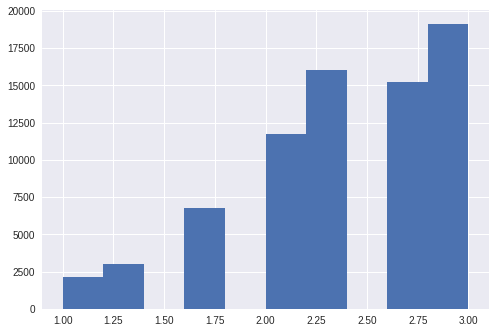

In [196]:
training_data.relevance.hist()

We see that the target is not normally distributed, lets be more specific.

In [197]:
training_data.relevance.value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

We see that the target is very unbalanced and tends towards the higher values.

In [198]:
mean = np.mean(training_data['relevance'])
print(f'The mean is: {mean}')

The mean is: 2.381633791027016


As expected from data that has a bias to upper values.

We will need to address that fact in our validation startegy, choosing Stratified K Fold can be nice but the simple method from scikit learn is built for classification tasks.

Lets check how the relevance values are spread over the data

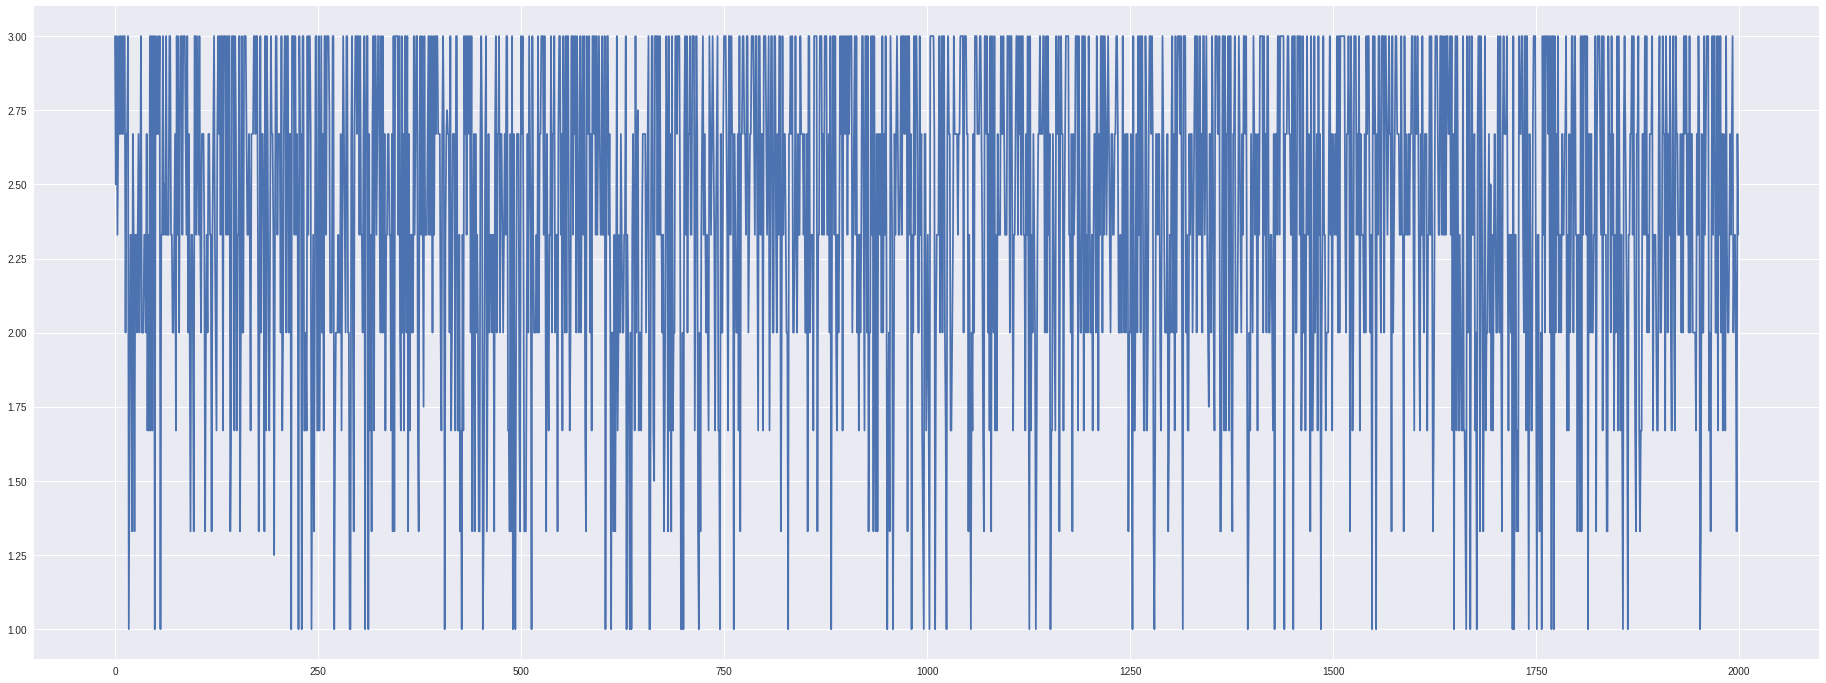

In [211]:
x = training_data[0:2000]['relevance']


x.plot(figsize=(32,12))

So the distribution is not normal but the values are spreaded evenlly. <br>
Next we can check distribution of test and train over a simple split

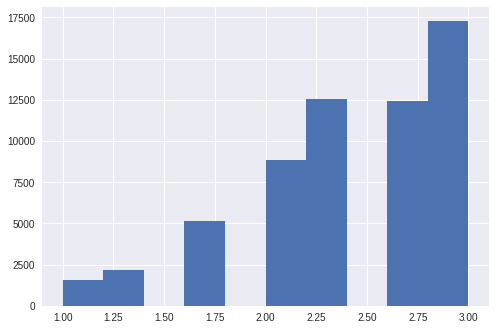

In [221]:
train = training_data[:60000]
train.relevance.hist()

In [223]:
mean = np.mean(train['relevance'])
print(f'The mean is: {mean}')

The mean is: 2.4168578333332675


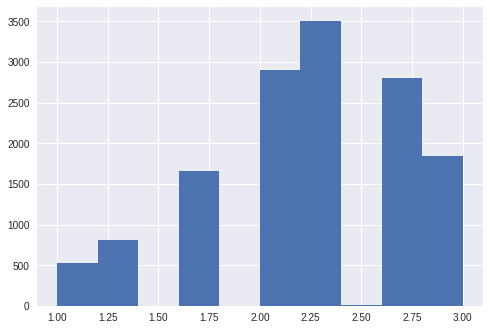

In [224]:
val = training_data[60000:]
val.relevance.hist()

In [226]:
mean = np.mean(val['relevance'])
print(f'The mean is: {mean}')

The mean is: 2.2313926210279327


We see that the distribution and mean is quiet similar so using a simple train-val split is not that bad.<br>
By taking this choice we aware that its not optimal and we might overfit our validation, but we decided to invest the limited time we have in other places (like researching more pretrained embedding and training a new one). <br>
If we had more time we would still like to apply a validation strategy similar to stratified k fold which will split the data to a bunch of folds and keep mean and distribution similar in every fold

# Baseline

At first, Lets create the most Naive baseline by submitting the mean of all training data as the score and evaluate our rmse from that.

In [0]:
mean = np.mean(training_data['relevance'])

In [0]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(training_data['relevance'].values, np.zeros(training_data.shape[0]) + mean))
print(f'rmse of train against mean: {rmse}')

rmse of train against mean: 0.5339803436691322


In [237]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(training_data['relevance'].values, np.zeros(training_data.shape[0]) + mean)


0.46979131158657317

The result looks not that naive, probably because the data is unbalanced and tends to the higher values. <br>
Considering the best LB score is 0.43 and the median is 0.48 We can stick to that baseline meanwhile.

# Character level LSTM 

## Creating Character embedding

In Small tests that we've done we found that stemming gives worse results in that scenario.
It makes sense for us as stemming can switch between characters and lose the special connection between them in a sentence.

So first we will label encode our data

In [0]:
cols = ['search_term', 'product_description']

In [0]:
%%time

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

for index, row in training_data.iterrows():

    # Iterate through the text of both questions of the row
    for question in cols:

        q2n = []  # q2n -> question numbers representation
#       for word in text_to_word_list(row[question]):
        for char in [a for a in row[question]]:
            #char = char.lower()
            if char not in vocabulary:
                vocabulary[char] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(char)
            else:
                q2n.append(vocabulary[char])

        # Replace questions as word to question as number representation
        training_data.set_value(index, question, q2n)
            


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


CPU times: user 29.6 s, sys: 133 ms, total: 29.7 s
Wall time: 29.7 s


Second, we will create a fake mission in order the generate an embedding representation for each char. <br>
Here we are creating a dataset containing chars as features and their surroundings as target feature.

We can create embeddings for characters in search_term and product_description or either create individual embeddings for each feature. <br>
Lets start by creating embeddings for both as it makes more sense right now. <br>
We can also use gensim Word2Vec algorithm but we found it to be less usefull in finding Character Embeddings

In [0]:
x_train, y_train = [] , []

for index, row in training_data.iterrows():

    # Iterate through the text of both questions of the row
    for col in cols:
        padding = row[col].copy()
        padding.append(6)
        padding.insert(0,6)       
        for i in range(1, len(padding)-1):          
            char = padding[i]
            backChar = padding[i-1]
            nextChar = padding[i+1]

            x_train.append(char)
            y_train.append([backChar,nextChar])
            
    if len(x_train) > 500000:
        break

x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
from keras.utils import to_categorical

backCharCategorical = to_categorical(y_train[:,0])
nextCharCategorical = to_categorical(y_train[:,1])

print(backCharCategorical.shape)
print(nextCharCategorical.shape)

(501047, 84)
(501047, 84)


In [0]:
embeddingSize = backCharCategorical.shape[1]
embeddingSize

In [0]:
from keras.regularizers import l2

input_vec = Input(shape=(1,))

emb = Embedding(embeddingSize, 16, embeddings_regularizer=l2(1e-3))(input_vec)
flat = Flatten()(emb)

out_back = Dense(embeddingSize, activation='softmax')(flat)
out_next = Dense(embeddingSize, activation='softmax')(flat)

model = Model(inputs = input_vec, outputs = [out_back, out_next])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
hist = model.fit(x_train, [backCharCategorical, nextCharCategorical], batch_size=256, epochs=20)

Epoch 1/20
501047/501047 [==============================] - 14s 27us/step - loss: 6.0669 - dense_4_loss: 3.0017 - dense_5_loss: 2.9942 - dense_4_acc: 0.1902 - dense_5_acc: 0.1984
Epoch 2/20
501047/501047 [==============================] - 13s 26us/step - loss: 5.4514 - dense_4_loss: 2.6723 - dense_5_loss: 2.6733 - dense_4_acc: 0.2263 - dense_5_acc: 0.2348
Epoch 3/20
501047/501047 [==============================] - 13s 26us/step - loss: 5.3753 - dense_4_loss: 2.6369 - dense_5_loss: 2.6414 - dense_4_acc: 0.2281 - dense_5_acc: 0.2364
Epoch 4/20
501047/501047 [==============================] - 13s 26us/step - loss: 5.3380 - dense_4_loss: 2.6235 - dense_5_loss: 2.6277 - dense_4_acc: 0.2288 - dense_5_acc: 0.2370
Epoch 5/20
501047/501047 [==============================] - 13s 26us/step - loss: 5.3142 - dense_4_loss: 2.6158 - dense_5_loss: 2.6197 - dense_4_acc: 0.2292 - dense_5_acc: 0.2369
Epoch 6/20
501047/501047 [==============================] - 13s 26us/step - loss: 5.2975 - dense_4_loss: 

Now we will use the Flatten layer as our output layer and will create a modle that output our embedding representation for each char

In [0]:
embeddingModel = Model(input_vec, flat)

In [0]:
uniqLabels = np.unique(x_train)

In [0]:
embeddingPredictions = embeddingModel.predict(uniqLabels)

We can reduce each char 16 dimension representaion to a 2d representation using TSNE and plot them to see if our embedding have found reasonable connections

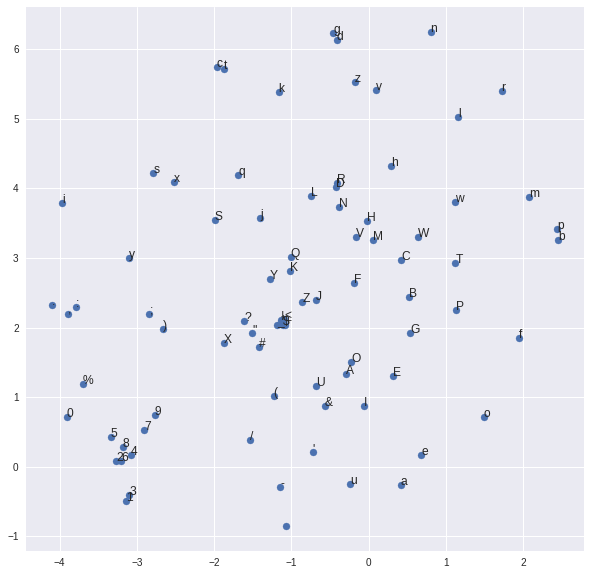

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
result = TSNE().fit_transform(embeddingPredictions)
plt.scatter(result[:, 0], result[:, 1])


for i in range(0,83):
 	plt.annotate(inverse_vocabulary[i+1], xy=(result[i, 0], result[i, 1]))
plt.show()

In the plot we can see seperation between digits lowercase and uppercase chars thus, we will trust the resulted embedding as a meaningfull representation and save it for use later.

In [0]:
model.save_weights("drive/My Drive/embeddingCharModel_Last30.h5")

np.save("drive/My Drive/CharEmbeddingPredictions.npy", embeddingPredictions)


In [0]:
model_yaml = model.to_yaml()
with open("drive/My Drive/embeddingCharModel_20_91.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [0]:
from keras.models import model_from_yaml
# load YAML and create model
yaml_file = open('drive/My Drive/embeddingCharModel.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("drive/My Drive/embeddingCharModel.h5")
print("Loaded model from disk")

embeddingPredictions = np.load("drive/My Drive/CharEmbeddingPredictions.npy")

Loaded model from disk


## Siamese network with Character LSTM 


We used here simple split to Train and Validation. <br>
Our main idea is that we want to build a simple model first, stabilize it and then use more complex  validation strategies as we make our model more complex.

In [0]:
X = training_data[cols]

In [0]:
Y = training_data['relevance']

In [0]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

In [0]:
# Split to dicts
X_train = {'left': X_train.search_term, 'right': X_train.product_description}
X_validation = {'left': X_validation.search_term, 'right': X_validation.product_description}

In [0]:
# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

Next step will be to trunc and pad all sequences in order to get a uniform sequence length. <br>
To find the best sequence length we will retrieve some statistics about our sequences

In [0]:
sumA = 0
maxA = 0
for x in training_data.search_term:
    if sumA ==0:
        minA = len(x)
    sumA += len(x)
    if len(x) > maxA:
        maxA = len(x)
    if len(x) < minA:
        minA = len(x)
    

print(f'mean: {sumA / len(training_data.search_term)}')
print(f'max: {maxA}')
print(f'min: {minA}')

mean: 19.008924352275642
max: 60
min: 2


In [0]:
sumA = 0
maxA = 0
for x in training_data.product_description:
    if sumA ==0:
        minA = len(x)
    sumA += len(x)
    if len(x) > maxA:
        maxA = len(x)
    if len(x) < minA:
        minA = len(x)
    

print(f'mean: {sumA / len(training_data)}')
print(f'max: {maxA}')
print(f'min: {minA}')

mean: 885.663750388162
max: 5516
min: 153


Setting the mean of each feature as the Length can be a good balanced choice, we dont want to lose data in long sequences but also we would rather not add noise with padding for small sequences. <br>
Later we found that using big numbers over here makes the running time skyrocket, we will have to compromise on smaller values, plus increasing size for search sentences will increase results.

In [0]:
# maxSearchLength = 60
# maxDescLength = 5516
maxSearchLength = 50
maxDescLength = 128

# Zero padding
X_train['left'] = pad_sequences(X_train['left'], maxlen=maxSearchLength )
X_train['right'] = pad_sequences(X_train['right'], maxlen=maxDescLength )
X_validation['left'] = pad_sequences(X_validation['left'],  maxlen=maxSearchLength)
X_validation['right'] = pad_sequences(X_validation['right'],  maxlen=maxDescLength)
   

# Make sure everything is ok
assert len(X_train['left']) == len(Y_train)
assert len(X_validation['left']) == len(Y_validation)

Creating embedding matrix to be used in Embedding layers of model

In [0]:
embedding_dim = 16
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored


# Build the embedding matrix
for word, index in vocabulary.items():
    if index in uniqLabels:
        embeddings[index] = embeddingPredictions[index-1]
       

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.Char_embedding_16_shorter.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

Last step is normalizing our target, real values are in range [1,3] but our model with manhattan_distance as Last layer's activation function can only produce values in range [0,1]

In [0]:
normalizeY_train = (Y_train - 1) /2
normalizeY_validation = (Y_validation - 1) /2

### Training model with no shared layers and Manhatten distance as output function

In [0]:
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 15

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# LSTM for each, different from classical siamese
left_lstm = LSTM(leftN_hidden)
right_lstm = LSTM(rightN_hidden)

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)

# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                         output_shape=lambda x: (x[0][0], 1))([left_LstmOutput, right_LstmOutput])

# Pack it all up into a model
malstm = Model([left_input, right_input], malstm_distance)

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)
# optimizer = Adam()


malstm.compile(loss=root_mean_squared_error, optimizer=optimizer)


malstm_trained = malstm.fit([X_train['left'], X_train['right']], normalizeY_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], normalizeY_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/15
59253/59253 [==============================] - 180s 3ms/step - loss: 0.5988 - val_loss: 0.5609

Epoch 00001: val_loss improved from inf to 0.56088, saving model to drive/My Drive/weights.Char_embedding_16_shorter.df5
Epoch 2/15
59253/59253 [==============================] - 179s 3ms/step - loss: 0.4847 - val_loss: 0.3695

Epoch 00002: val_loss improved from 0.56088 to 0.36955, saving model to drive/My Drive/weights.Char_embedding_16_shorter.df5
Epoch 3/15
59253/59253 [==============================] - 179s 3ms/step - loss: 0.4142 - val_loss: 0.4287

Epoch 00003: val_loss did not improve from 0.36955
Epoch 4/15
59253/59253 [==============================] - 179s 3ms/step - loss: 0.3705 - val_loss: 0.2918

Epoch 00004: val_loss improved from 0.36955 to 0.29179, saving model to drive/My Drive/weights.Char_embedding_16_shorter.df5
Epoch 5/15
59253/59253 [==============================] - 179s 3ms/step - loss: 0.3364 - val_loss: 0

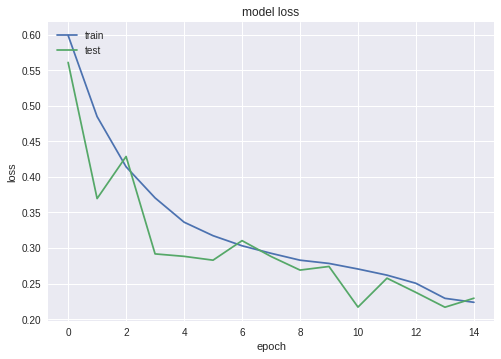

In [0]:
# summarize history for loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
malstm.load_weights('drive/My Drive/weights.Char_embedding_16_shorter.df5')
pred = malstm.predict([X_train['left'], X_train['right']])

In [0]:
from sklearn.metrics import mean_squared_error

predUnNormalized = (pred *2.0) +1.0

print("Validation RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(Y_train, predUnNormalized))))
# print(f"RMSE score: {root_mean_squared_error(Y_validation, predUnNormalized)}")

Validation RMSE score: 0.53392 


Ok nice,  similar to our Naive baseline, now we can try to take the most out of this architecture.  <br>
Next we tweaked the following parameters:  

    Differnce function can be either cosine similarity or Manhattan distance.
    Loss function can be changed to mse or mae.
    Some layers could be shared.
    Different Optimizers.
    Better weights initializer.
    More/less nodes for LSTM.
    Improve Embeddings.
    Change padding size.
    Train to unNormalized targets.

## Winning model:

Eventually the best model we found was with the following parameters:

cosine, no shared layers, desc padding 128, search padding  50, Lstm nodes 100, adam

In [0]:
from keras.layers import dot

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.Char_embedding_cos_unnorm_weight_init_75ep_.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
# Model variables
leftN_hidden = 100
rightN_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 75


# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
#                          output_shape=lambda x: (x[0][0], 1))([left_LstmOutput, right_LstmOutput])

cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)

cos_model = Model([left_input, right_input], norm)
# Pack it all up into a model
# malstm = Model([left_input, right_input], malstm_distance)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()


cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/75
60000/60000 [==============================] - 213s 4ms/step - loss: 0.2979 - val_loss: 0.2769

Epoch 00001: val_loss improved from inf to 0.27693, saving model to drive/My Drive/weights.Char_embedding_cos_unnorm_weight_init_75ep_.df5
Epoch 2/75
60000/60000 [==============================] - 213s 4ms/step - loss: 0.2785 - val_loss: 0.2778

Epoch 00002: val_loss did not improve from 0.27693
Epoch 3/75
60000/60000 [==============================] - 217s 4ms/step - loss: 0.2770 - val_loss: 0.2740

Epoch 00003: val_loss improved from 0.27693 to 0.27402, saving model to drive/My Drive/weights.Char_embedding_cos_unnorm_weight_init_75ep_.df5
Epoch 4/75
60000/60000 [==============================] - 214s 4ms/step - loss: 0.2756 - val_loss: 0.2743

Epoch 00004: val_loss did not improve from 0.27402
Epoch 5/75
60000/60000 [==============================] - 215s 4ms/step - loss: 0.2749 - val_loss: 0.2746

Epoch 00005: val_loss did not i

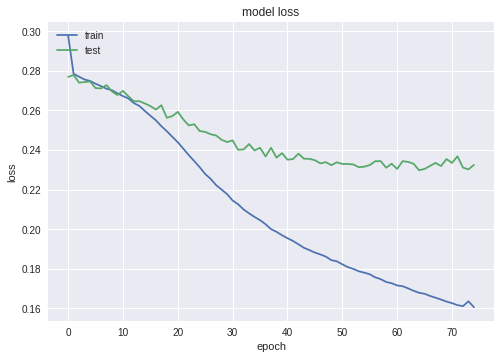

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.39953 
Train MAE loss: 0.32367165976945556
Validation RMSE score: 0.47932 
Validation MAE loss: 0.3855941388845494


So our best result comes with a big overfit to the train, maybe adding regulations here could help improve even better.

## Feature Extracting

Now we'll take our best model and use its last layer as features for classic ML model. <br>
We will use the output from the LSTM layers as our features, then train RandomForest and LGBM over that extracted features.

In [0]:
# Model variables
leftN_hidden = 100
rightN_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 75


# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
#                          output_shape=lambda x: (x[0][0], 1))([left_LstmOutput, right_LstmOutput])

cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)

cos_model = Model([left_input, right_input], norm)
# Pack it all up into a model
# malstm = Model([left_input, right_input], malstm_distance)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()


cos_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [0]:
cos_model.load_weights("drive/My Drive/weights.Char_embedding_cos_unnorm_weight_init_75ep_.df5")

Creating Feature extractor model

In [0]:
featureExtractor = Model(inputs = cos_model.input, outputs = cos_model.get_layer('dot_1').input)

Extracting features for train and Val

In [0]:
predFeatures = featureExtractor.predict([X_train['left'], X_train['right']])

In [0]:
predFeaturesTrain = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

In [0]:
predFeatures = featureExtractor.predict([X_validation['left'], X_validation['right']])
predFeaturesVal = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

### Random Forest

In [0]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 50, max_depth = 10)
forest.fit(predFeaturesTrain, Y_train)

CPU times: user 5min 37s, sys: 0 ns, total: 5min 37s
Wall time: 5min 37s


In [0]:
pred_train = forest.predict(predFeaturesTrain)
pred_val = forest.predict(predFeaturesVal)

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.39849 
Train MAE loss: 0.3256942535181866
Validation RMSE score: 0.44675 
Validation MAE loss: 0.35992516505223576


Great success! <br>
We see here a big improvment over validation score and no improvment in train score, Random Forest managed to lower the overfitting we had in our model and create a more generalized model. 

### LightGBM

In [0]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [0]:
import lightgbm as lgb

trn_data = lgb.Dataset(predFeaturesTrain, label=Y_train)
val_data = lgb.Dataset(predFeaturesVal, label=Y_validation)

num_round = 11000
clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.466163	valid_1's rmse: 0.468809
[200]	training's rmse: 0.444146	valid_1's rmse: 0.450375
[300]	training's rmse: 0.432924	valid_1's rmse: 0.442358
[400]	training's rmse: 0.425589	valid_1's rmse: 0.437865
[500]	training's rmse: 0.420145	valid_1's rmse: 0.435223
[600]	training's rmse: 0.415772	valid_1's rmse: 0.433603
[700]	training's rmse: 0.41203	valid_1's rmse: 0.432566
[800]	training's rmse: 0.40868	valid_1's rmse: 0.431893
[900]	training's rmse: 0.405567	valid_1's rmse: 0.431276
[1000]	training's rmse: 0.402629	valid_1's rmse: 0.430876
[1100]	training's rmse: 0.399817	valid_1's rmse: 0.430546
[1200]	training's rmse: 0.397194	valid_1's rmse: 0.430265
[1300]	training's rmse: 0.394589	valid_1's rmse: 0.430103
[1400]	training's rmse: 0.392074	valid_1's rmse: 0.429866
[1500]	training's rmse: 0.389675	valid_1's rmse: 0.429707
[1600]	training's rmse: 0.387333	valid_1's rmse: 0.429556
[1700]	training's rm

In [0]:
pred_train = clf.predict(predFeaturesTrain, num_iteration=clf.best_iteration)
pred_val = clf.predict(predFeaturesVal, num_iteration=clf.best_iteration)    

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.37502 
Train MAE loss: 0.3026244272006245
Validation RMSE score: 0.42922 
Validation MAE loss: 0.34146367001979205


Even greater success! <br>
We see here a big improvment over validation score and train score, ### LightGBM managed to lower the overfitting we had in our original model and even learn more from the features.

#Test


As the competition results are published we can now test our models on the real test data set.<br>
We decided to keep the test dataset hidden from us until finishing all work in order to not overfit it.

In [0]:
# Merge descriptions
testing_data= pd.merge(testing_data, test_sol, 
                         on="id", how="left")

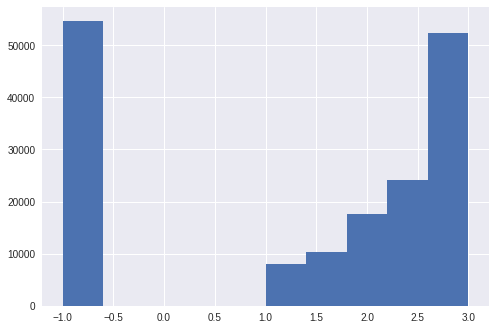

In [239]:
testing_data.relevance.hist()

Some of the test dataset is garbage, we can remove it

In [0]:
testing_data = testing_data[testing_data.relevance != -1]

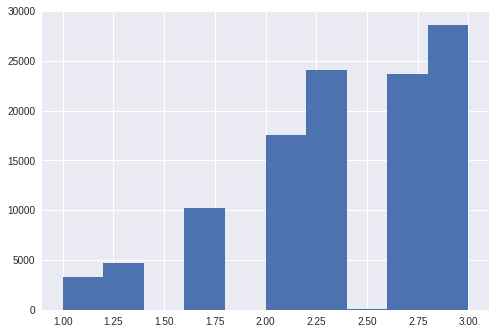

In [185]:
testing_data.relevance.hist()

Then splitting the dataset to public and private will make our work closer to the original kaggle competition

In [0]:
privateTesting_data = testing_data[testing_data.Usage == 'Private']
publicTesting_data = testing_data[testing_data.Usage == 'Public']

## Checking naive model over Test

In [188]:
mean = np.mean(training_data['relevance'])
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(privateTesting_data['relevance'].values, np.zeros(privateTesting_data.shape[0]) + mean))
print(f'rmse of private test against mean: {rmse}')

rmse = np.sqrt(mean_squared_error(publicTesting_data['relevance'].values, np.zeros(publicTesting_data.shape[0]) + mean))
print(f'rmse of public test against mean: {rmse}')

rmse of private test against mean: 0.5351332724605377
rmse of public test against mean: 0.5355976215380717


In [244]:
from sklearn.metrics import mean_absolute_error

mean = np.mean(training_data['relevance'])

mae = mean_absolute_error(privateTesting_data['relevance'].values, np.zeros(privateTesting_data.shape[0]) + mean)
print(f'mae of private test against mean: {mae}')

mae = mean_absolute_error(publicTesting_data['relevance'].values, np.zeros(publicTesting_data.shape[0]) + mean)
print(f'mae of public test against mean: {mae}')


mae of private test against mean: 0.4388503166548874
mae of public test against mean: 0.43838713727956113


Interesting, the rmse of our Naive model over test is very close to the rmse of our naive model over train. <br>
We can assume that the data in the test is distributed similarly as in the train and our models have a chance of genralizing from train to test

**Preparing test data set**

In [0]:
cols = ['search_term', 'product_description']

In [0]:
%%time

for index, row in publicTesting_data.iterrows():

    for col in cols:
        q2n = []  # q2n -> question numbers representation
        for char in [a for a in row[col]]:
            q2n.append(vocabulary[char])

        # Replace word as number representation
        publicTesting_data.set_value(index, col, q2n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 11.5 s, sys: 192 ms, total: 11.7 s
Wall time: 11.7 s


In [0]:
%%time

for index, row in privateTesting_data.iterrows():

    for col in cols:
        q2n = []  # q2n -> question numbers representation
        for char in [a for a in row[col]]:
            q2n.append(vocabulary[char])

        # Replace word as number representation
        privateTesting_data.set_value(index, col, q2n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 29.9 s, sys: 403 ms, total: 30.3 s
Wall time: 30.3 s


In [0]:
X_privateTest = privateTesting_data[cols]
X_privateTest = {'left': X_privateTest.search_term, 'right': X_privateTest.product_description}
Y_privateTest = privateTesting_data['relevance']

X_publicTest = publicTesting_data[cols]
X_publicTest = {'left': X_publicTest.search_term, 'right': X_publicTest.product_description}
Y_publicTest = publicTesting_data['relevance']

In [0]:
maxSearchLength = 50
maxDescLength = 128

# Zero padding
X_privateTest['left'] = pad_sequences(X_privateTest['left'], maxlen=maxSearchLength )
X_privateTest['right'] = pad_sequences(X_privateTest['right'], maxlen=maxDescLength )


In [0]:
X_publicTest['left'] = pad_sequences(X_publicTest['left'], maxlen=maxSearchLength )
X_publicTest['right'] = pad_sequences(X_publicTest['right'], maxlen=maxDescLength )

##Testing Siamese network with Character LSTM

In [0]:
embeddingPredictions = np.load("drive/My Drive/CharEmbeddingPredictions.npy")

In [0]:
uniqLabels

In [0]:
uniqLabels = np.array([x for x in range(1,84)])

In [0]:
embedding_dim = 16
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored


# Build the embedding matrix
for word, index in vocabulary.items():
    if index in uniqLabels:
        embeddings[index] = embeddingPredictions[index-1]
       

In [0]:
# Model variables
leftN_hidden = 100
rightN_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 75


# The visible layer
left_input = Input(shape=(X_publicTest['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_publicTest['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
#                          output_shape=lambda x: (x[0][0], 1))([left_LstmOutput, right_LstmOutput])

cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)

cos_model = Model([left_input, right_input], norm)
# Pack it all up into a model
# malstm = Model([left_input, right_input], malstm_distance)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()


cos_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [0]:
cos_model.load_weights('drive/My Drive/weights.Char_embedding_cos_unnorm_weight_init_75ep_.df5')

In [0]:
pred_privateTest= cos_model.predict([X_privateTest['left'], X_privateTest['right']])

pred_publicTest= cos_model.predict([X_publicTest['left'], X_publicTest['right']])

In [0]:
print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_privateTest))))
print('Private Test MAE loss: {}'.format(mean_absolute_error(Y_privateTest, pred_privateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_publicTest))))
print('Public Test MAE loss: {}'.format(mean_absolute_error(Y_publicTest, pred_publicTest)))

Private Test RMSE score: 0.54776 
Private Test MAE loss: 0.44156092904274674
Public Test RMSE score: 0.54806 
Public Test MAE loss: 0.442088226710707


This is our train and validation results:

Train RMSE score: 0.39953 <br>
Train MAE loss: 0.32367165976945556 <br>
Validation RMSE score: 0.47932 <br>
Validation MAE loss: 0.3855941388845494 <br>

There is a big drop in our results between the test results and the validation results. <br>
So either our validation is not representing the test and real world or we somehow managed to overfit also validation set and our model didnt learn anything usefull. <br>
We tend to think the first option is the correct one, lets continue investigating.


##Testing Siamese network as FE and Random Forest as classifier

In [0]:
%%time
featureExtractor = Model(inputs = cos_model.input, outputs = cos_model.get_layer('dot_1').input)

predFeatures = featureExtractor.predict([X_train['left'], X_train['right']])
predFeaturesTrain = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

predFeatures = featureExtractor.predict([X_validation['left'], X_validation['right']])
predFeaturesVal = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

predFeatures = featureExtractor.predict([X_publicTest['left'], X_publicTest['right']])
predFeaturesPublicTest = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

predFeatures = featureExtractor.predict([X_privateTest['left'], X_privateTest['right']])
predFeaturesPrivateTest = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)


In [0]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 50, max_depth = 10)
forest.fit(predFeaturesTrain, Y_train)

CPU times: user 5min 52s, sys: 0 ns, total: 5min 52s
Wall time: 5min 52s


In [0]:
pred_train = forest.predict(predFeaturesTrain)
pred_val = forest.predict(predFeaturesVal)

pred_PublicTest = forest.predict(predFeaturesPublicTest)
pred_PrivateTest = forest.predict(predFeaturesPrivateTest)

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_PrivateTest))))
print('Private Test MAE loss: {}'.format(mean_absolute_error(Y_privateTest, pred_PrivateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_PublicTest))))
print('Public Test MAE loss: {}'.format(mean_absolute_error(Y_publicTest, pred_PublicTest)))

Train RMSE score: 0.39874 
Train MAE loss: 0.32581557159456115
Validation RMSE score: 0.44995 
Validation MAE loss: 0.36369017340053883
Private Test RMSE score: 0.54471 
Private Test MAE loss: 0.4388274695870023
Public Test RMSE score: 0.54491 
Public Test MAE loss: 0.43972805522452435


Still 0.54X RMSE over test with random forest 

##Testing Siamese network as FE and LightGBM as classifier

In [0]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [0]:
import lightgbm as lgb

trn_data = lgb.Dataset(predFeaturesTrain, label=Y_train)
val_data = lgb.Dataset(predFeaturesVal, label=Y_validation)

num_round = 11000
clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.465435	valid_1's rmse: 0.472477
[200]	training's rmse: 0.443637	valid_1's rmse: 0.453353
[300]	training's rmse: 0.432481	valid_1's rmse: 0.445013
[400]	training's rmse: 0.425151	valid_1's rmse: 0.440338
[500]	training's rmse: 0.419812	valid_1's rmse: 0.437756
[600]	training's rmse: 0.415548	valid_1's rmse: 0.436191
[700]	training's rmse: 0.411876	valid_1's rmse: 0.435164
[800]	training's rmse: 0.408583	valid_1's rmse: 0.434535
[900]	training's rmse: 0.405531	valid_1's rmse: 0.434065
[1000]	training's rmse: 0.402632	valid_1's rmse: 0.433675
[1100]	training's rmse: 0.399869	valid_1's rmse: 0.43329
[1200]	training's rmse: 0.397205	valid_1's rmse: 0.433076
[1300]	training's rmse: 0.394669	valid_1's rmse: 0.432839
[1400]	training's rmse: 0.392182	valid_1's rmse: 0.432625
[1500]	training's rmse: 0.389745	valid_1's rmse: 0.432436
[1600]	training's rmse: 0.387427	valid_1's rmse: 0.432322
[1700]	training's r

In [0]:
pred_train = clf.predict(predFeaturesTrain, num_iteration=clf.best_iteration)
pred_val = clf.predict(predFeaturesVal, num_iteration=clf.best_iteration)    

pred_PublicTest = clf.predict(predFeaturesPublicTest, num_iteration=clf.best_iteration)    
pred_PrivateTest = clf.predict(predFeaturesPrivateTest, num_iteration=clf.best_iteration)    

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_PrivateTest))))
print('Private Test MAE loss: {}'.format(mean_absolute_error(Y_privateTest, pred_PrivateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_PublicTest))))
print('Public Test MAE loss: {}'.format(mean_absolute_error(Y_publicTest, pred_PublicTest)))

Train RMSE score: 0.38268 
Train MAE loss: 0.30813175560710804
Validation RMSE score: 0.43208 
Validation MAE loss: 0.34643409937140757
Private Test RMSE score: 0.54949 
Private Test MAE loss: 0.4417253629048999
Public Test RMSE score: 0.54963 
Public Test MAE loss: 0.4427468815443645


And still 0.54X RMSE over test with LightGBM

There are two causes we can think of for that phenomena:<br>
1.We overfitted the validation dataset
2.There are changes in character level connections between validation and Test 

We tend to think that in this task a model based on character connections cant generalize well to Test becuase of the second reason. <br>
We might overfitted a bit the validation set but we think that it cant explain the big differnce in test score and validation score, especially when that big jump is taking three of our models with different results to the same score pretty much.

If we had more time and resources we think that next steps over here will be to try with better validation strategy and add regulation (like dropouts) to our model.


## Stay tuned for word embeddings on the next chapter